In [2]:
from converters import convert_cif_to_mol, convert_xyz_to_mol

ModuleNotFoundError: No module named 'converters'

In [ ]:
mol = convert_cif_to_mol("1572856.cif")

print(Chem.MolToSmiles(mol))

[C][N][N].[H].[Ni].[Ni]


In [ ]:
c = mol.GetConformer(0)

c.GetNumAtoms()

94

In [ ]:
c.GetAtomPosition(0).y

7.6875

In [ ]:
from converters import convert_xyz_to_mol

mol = convert_xyz_to_mol("dsgdb9nsd_000087.xyz")

# print SMILES
print(Chem.MolToSmiles(mol))

[H]C([H])([H])C1(C([H])([H])[H])OC1([H])[H]


In [ ]:
c = mol.GetConformer(0)

[c.GetAtomPosition(i).x for i in range(c.GetNumAtoms())]

[-0.0397,
 -0.0302,
 -1.2461,
 0.7894,
 1.2255,
 0.8899,
 -0.8795,
 -0.1445,
 -2.1522,
 -1.1341,
 -1.3859,
 0.5071,
 1.3709]

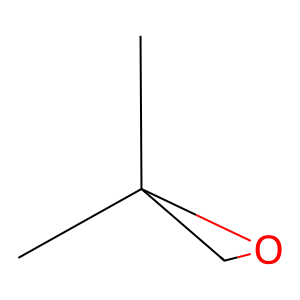

In [ ]:
# canonicalize the molecule and draw it
# mol = convert_xyz_to_mol('dsgdb9nsd_000087.xyz')
mol = Chem.RemoveHs(mol)

Draw.MolToImage(mol)

In [ ]:
import numpy as np
from rdkit import Chem


def validate_xyz_conversion(xyz_file: str, rdkit_mol: Chem.rdchem.Mol) -> bool:
    """
    Validate the conversion by comparing atomic coordinates and composition.

    Args:
        xyz_file (str): Path to the original XYZ file
        rdkit_mol (rdkit.Chem.rdchem.Mol): Converted RDKit molecule

    Returns:
        bool: True if validation passes, False otherwise
    """
    # Read original XYZ coordinates
    with open(xyz_file, "r") as f:
        lines = f.readlines()

    n_atoms = int(lines[0])
    xyz_coords = []
    xyz_atoms = []

    gtSmiles = lines[-2].strip().replace(" ", "")
    # canonicalize the SMILES
    gtMol = Chem.MolFromSmiles(gtSmiles)
    gtMol = Chem.Mol(gtMol)
    gtMol = Chem.AddHs(gtMol)
    Chem.SanitizeMol(gtMol)

    gtSmiles = Chem.MolToSmiles(gtMol)

    smi = Chem.MolToSmiles(rdkit_mol)
    # assert gtSmiles == smi, f"SMILES mismatch: {gtSmiles} != {smi}"

    assert (
        gtMol.GetNumAtoms() == rdkit_mol.GetNumAtoms()
    ), f"Number of atoms mismatch: {gtMol.GetNumAtoms()} != {rdkit_mol.GetNumAtoms()}"

    for line in lines[2 : n_atoms + 2]:
        atom, x, y, z, _ = line.replace("*^", "e").split()
        xyz_atoms.append(atom)
        xyz_coords.append([float(x), float(y), float(z)])

    xyz_coords = np.array(xyz_coords)

    # Get RDKit coordinates
    conf = rdkit_mol.GetConformer()
    rdkit_coords = conf.GetPositions()
    rdkit_atoms = [atom.GetSymbol() for atom in rdkit_mol.GetAtoms()]

    # Compare number of atoms
    if len(xyz_atoms) != len(rdkit_atoms):
        print("Number of atoms mismatch!")
        return False

    # Compare atomic composition
    assert xyz_atoms == rdkit_atoms

    # Compare coordinates (with small tolerance for numerical differences)
    coord_diff = np.abs(xyz_coords - rdkit_coords).max()
    if coord_diff > 1e-3:
        print("Coordinates mismatch!")
        return False

    return True

In [ ]:
QM9_PATH = "/auto/home/davit/dsgdb9nsd.xyz/"
from tqdm import tqdm
import os
from converters import convert_xyz_to_mol

import traceback


def c():
    # List all files ending with .xyz
    xyz_files = [f for f in os.listdir(QM9_PATH) if f.endswith(".xyz") and "gdb" in f]
    pinv = 0
    inv = 0
    with_dot = 0
    for f in tqdm(xyz_files):
        try:
            mol = convert_xyz_to_mol(os.path.join(QM9_PATH, f))
        except ValueError as e:
            pass
        except Exception as e:
            pinv += 1
            traceback.print_exc()

            print("FAILED PATH: ", os.path.join(QM9_PATH, f))
            return

        assert mol is not None
        smi = Chem.MolToSmiles(mol)
        assert smi != ""
        with_dot += "." in smi

        inv += validate_xyz_conversion(os.path.join(QM9_PATH, f), mol)

    print(f"Can't parse: {pinv}")
    print(f"Invalid: {inv}")
    print(f"With dot: {with_dot}")

In [ ]:
c()

  0%|          | 0/133885 [00:00<?, ?it/s]==============================
*** Open Babel Error  in TetStereoToWedgeHash
  Failed to set stereochemistry as unable to find an available bond
*** Open Babel Error  in TetStereoToWedgeHash
  Failed to set stereochemistry as unable to find an available bond
*** Open Babel Error  in TetStereoToWedgeHash
  Failed to set stereochemistry as unable to find an available bond
*** Open Babel Error  in TetStereoToWedgeHash
  Failed to set stereochemistry as unable to find an available bond
*** Open Babel Error  in TetStereoToWedgeHash
  Failed to set stereochemistry as unable to find an available bond
*** Open Babel Error  in TetStereoToWedgeHash
  Failed to set stereochemistry as unable to find an available bond
*** Open Babel Warning  in PerceiveBondOrders
  Failed to kekulize aromatic bonds in OBMol::PerceiveBondOrders (title is gdb 132881	3.17896	1.44284	0.99241	1.4572	67.71	-0.2062	-0.049	0.1572	1066.246	0.089499	-494.061446	-494.05391	-494.052966

AssertionError: 

In [ ]:
mol = Chem.MolFromMolFile("./debug.mol", removeHs=False, sanitize=False)

gt_mol = Chem.MolFromSmiles("CN=C(N)N(C)C=O")
gt_mol = Chem.AddHs(gt_mol)
Chem.MolToSmiles(gt_mol)

print(Chem.MolToSmiles(mol))

gt_mol.GetProp("_smilesAtomOutputOrder")

[H]C(=O)N(C(NC([H])([H])[H])=N([H])[H])C([H])([H])[H]


'[16,6,7,4,2,1,0,8,9,10,3,11,12,5,13,14,15,]'

In [ ]:
convert_xyz_to_mol("/auto/home/davit/dsgdb9nsd.xyz/dsgdb9nsd_008782.xyz")

[17:17:09] Explicit valence for atom # 3 N, 4, is greater than permitted


ValueError: Failed to convert /auto/home/davit/dsgdb9nsd.xyz/dsgdb9nsd_008782.xyz to mol.

In [ ]:
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem.rdForceFieldHelpers import UFFGetMoleculeForceField
import pandas as pd
import numpy as np

from utils.converters import convert_xyz_to_mol


def optimize_conformer(mol, conf_id):
    """Optimize the geometry of a specific conformer."""
    ff = UFFGetMoleculeForceField(mol, confId=conf_id)
    ff.Minimize()
    return ff.CalcEnergy()


def add_and_optimize_conformers(mol, N, duplicate=True, perturb_scale=0.3):
    """Generate N conformers, optimize them, and return the average energy."""
    energies = [0]
    energies[0] = UFFGetMoleculeForceField(mol, confId=0).CalcEnergy()

    rmsds = []

    if not duplicate:
        AllChem.EmbedMultipleConfs(mol, numConfs=N, randomSeed=42)
    else:
        ref_conf = mol.GetConformer(0)
        # Get the positions from the reference conformer
        positions = ref_conf.GetPositions()
        # Create new conformers
        for i in range(N):
            # Create a new conformer
            new_conf = Chem.Conformer(mol.GetNumAtoms())

            if perturb_scale > 0:
                noise = np.random.normal(0, perturb_scale, positions.shape)
                positions += noise

            # Set the 3D positions from the reference conformer
            for j in range(mol.GetNumAtoms()):
                new_conf.SetAtomPosition(j, positions[j])
            # Add it to the molecule
            mol.AddConformer(new_conf, assignId=True)

    for conf_id in range(1, mol.GetNumConformers()):
        energy = optimize_conformer(mol, conf_id)
        energies.append(energy)
        rmsds.append(AllChem.GetConformerRMS(mol, 0, conf_id))

    df = pd.DataFrame({"energies": energies[1:], "rmsds": rmsds})
    # soft by rmsds
    df = df.sort_values("rmsds")

    # Compute the average energy of all N conformers (excluding the initial one)
    avg_energy_N_conformers = (
        sum(energies[1:]) / N
    )  # Exclude the initial conformer (index 0)

    # Return initial conformer energy and average energy of N conformers
    return energies[0], avg_energy_N_conformers, df


mol = convert_xyz_to_mol("/auto/home/davit/3DMolGen/tests/fixtures/aspirin.xyz")
mol = convert_xyz_to_mol(
    "/auto/home/davit/3DMolGen/tests/fixtures/dsgdb9nsd_000087.xyz"
)

# mol = Chem.SDMolSupplier("./data/conf.sdf")[0]
# print("EN: ", mol.GetProp("ENERGY"))

N = 25  # Number of additional conformers to generate
initial_energy, avg_energy_N_conformers, df = add_and_optimize_conformers(
    mol, N, duplicate=False, perturb_scale=0.3
)

print(f"Initial conformer energy: {initial_energy:.4f} kcal/mol")
print(f"Average energy of {N} conformers: {avg_energy_N_conformers:.4f} kcal/mol")

Initial conformer energy: 343.9519 kcal/mol
Average energy of 25 conformers: 326.1694 kcal/mol


/tmp/ipykernel_483099/602993368.py:9: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()
/tmp/ipykernel_483099/602993368.py:17: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


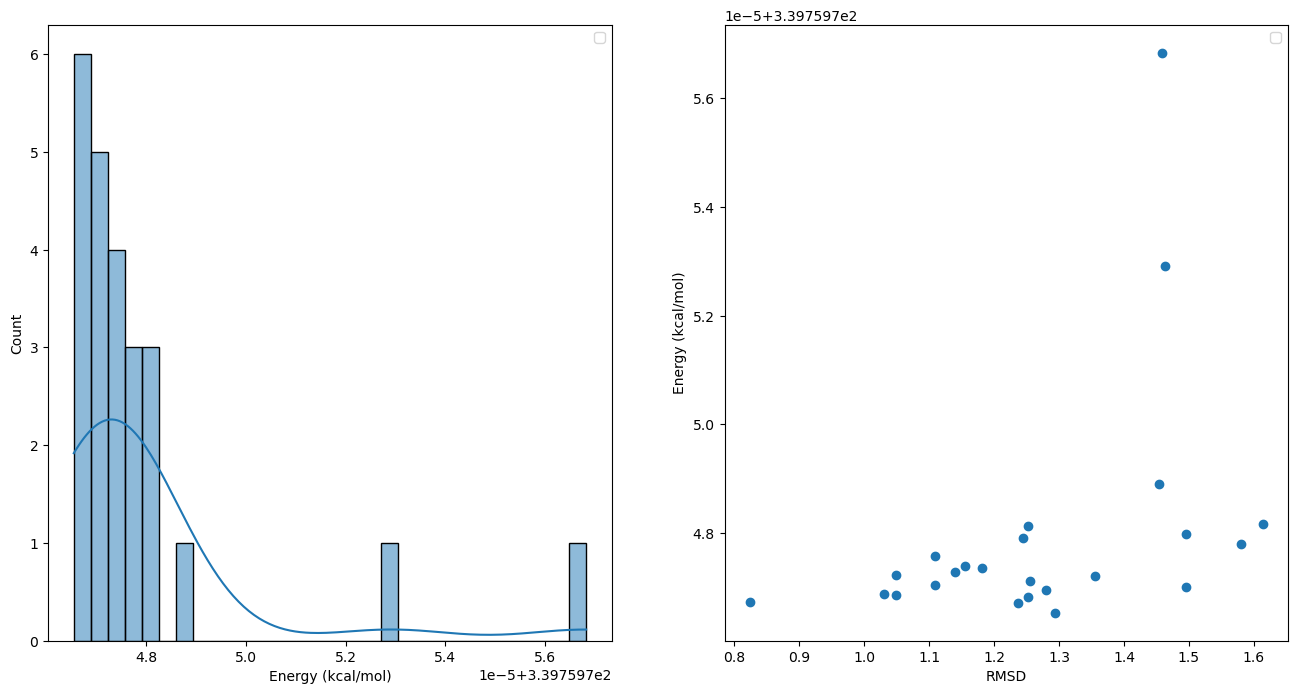

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plot the energy distribution of the generated conformers
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
sns.histplot(df["energies"], bins=30, kde=True)
plt.xlabel("Energy (kcal/mol)")
plt.legend()

# Line plot of RMSD vs. energy
plt.subplot(1, 2, 2)
plt.scatter(df["rmsds"], df["energies"], marker="o")
plt.xlabel("RMSD")
plt.ylabel("Energy (kcal/mol)")

plt.legend()
plt.show()

In [ ]:
from rdkit import Chem


from evaluation.conformer import calculate_rmsd, get_conformer_statistics
from utils.converters import convert_xyz_to_sdf


mol_path = "tests/fixtures/dsgdb9nsd_000087.xyz"
output_path = "./data/out.sdf"

convert_xyz_to_sdf(mol_path, output_path)

for mol in Chem.SDMolSupplier(output_path):
    pass

Chem.MolToSmiles(mol)

# Fluctuate one of the atoms
c = mol.GetConformer(0)
initial_pos = c.GetAtomPosition(0)

initial_pos.x += 0.1
initial_pos.y += 0.1
initial_pos.z += 0.1

c.SetAtomPosition(0, [initial_pos.x, initial_pos.y, initial_pos.z])

for gt_mol in Chem.SDMolSupplier(output_path):
    pass

print("RMSD: ", calculate_rmsd(mol, gt_mol))

res = get_conformer_statistics(mol, gt_mol)
res["resuts"]["bond_lengths"].iloc[0]

RMSD:  0.07745966692414837


np.True_

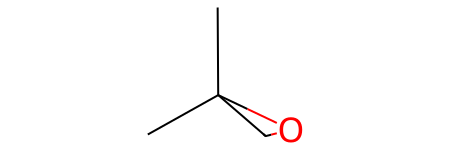

In [ ]:
from rdkit import Chem

m = list(Chem.SDMolSupplier("./data/out.sdf"))[0]

In [ ]:
print(res["resuts"][""].iloc[0])  # Index denotes molecule

nan
